In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300

In [2]:
class StimulationSequence:
  def __init__(self, N, N_patterns = 100, N_pattern_repeats = 20, Iscale = 1000, stimulation_period = 15, N_stimulated = 10, start_step = 5, end_step = 7):
    self.stimulation_period = stimulation_period
    self.N_patterns = N_patterns
    self.N_pattern_repeats = N_pattern_repeats
    self.U = np.zeros([N, N_patterns])
    for i in range(N_patterns):
      self.U[np.random.choice(range(N), N_stimulated), i] = 1

    I_presentations = np.ones([N_patterns, N_pattern_repeats]) * np.arange(N_patterns)[:,None]
    self.I_stimulationPattern = np.random.choice(I_presentations.ravel(), N_patterns * N_pattern_repeats, replace=False)
    self.I_stimulation = np.zeros([N_patterns, stimulation_period * N_patterns * (N_pattern_repeats + 1)])
    self.I_stimulation_start = np.zeros([N_patterns * N_pattern_repeats])
    for t, pattern in enumerate(self.I_stimulationPattern):
      self.I_stimulation[int(pattern), t * stimulation_period + start_step : t * stimulation_period + end_step] = Iscale
      self.I_stimulation_start[t] = t * stimulation_period + start_step
  def return_input_current(self, t):
    return self.U.dot(self.I_stimulation[:,t]).T[:,None]

class SNN:
  def __init__(self, Ncells = 600, g = 1, noise = 1, leak = 0.1, Catau = 3, Itau = 1, resetvoltage = 0.1):
    self.g = g
    self.N = Ncells
    self.noise = noise
    self.leak = leak
    self.Catau = Catau
    self.Itau = Itau
    self.resetvoltage = resetvoltage
    self.v = np.random.normal(0, 1, [self.N, 1])
    self.I = np.abs(np.random.normal(0, 1, [self.N, 1]))
    self.Ca = np.abs(np.random.normal(0, 1, [self.N, 1]))
    self.W = np.random.normal(0, g/np.sqrt(Ncells), [Ncells, Ncells])
    self.T = 1

  def nonlin(self):
    return self.v > self.T

  def runsimulation(self, numsteps = 1000, Iscale = 1000, dt = 0.05, stim_dt = 0.005, bias = 1, res='low'):
    self.numsteps = numsteps
    self.stim = StimulationSequence(self.N, Iscale = Iscale)
    steps_per_measurement = int(dt / stim_dt)
    vall = np.zeros([self.N, numsteps])
    Ca_all = np.zeros(vall.shape)
    Spikes_all = np.zeros(vall.shape)
    Stimulation_all = np.zeros(vall.shape)
    if res == 'high':
        vall_full = np.zeros([self.N, numsteps * steps_per_measurement])
        Ca_all_full = np.zeros(vall_full.shape)
        Spikes_all_full = np.zeros(vall_full.shape)
        Stimulation_all_full =np.zeros(vall_full.shape)
    for t in range(numsteps):
      for ss in range(steps_per_measurement):
        spike = self.nonlin()
        if ss ==0:
          s = spike
        else:
          s[spike] = True
        self.vold = np.copy(self.v)
        self.v = self.v + stim_dt * (-self.leak * self.v + self.W.dot(spike) + self.stim.U.dot(self.stim.I_stimulation[:,t]).T[:,None] + np.random.normal(bias, self.noise, self.v.shape))
        self.v[self.vold > self.T] = self.resetvoltage
        self.I[spike] += 1
        self.I = self.I - stim_dt * (self.I / self.Itau)
        self.Ca += self.I
        self.Ca = self.Ca - stim_dt * (self.Ca / self.Catau)
        if res == 'high':
            vall_full[:,t*steps_per_measurement + ss] = self.v.ravel()
            Ca_all_full[:,t*steps_per_measurement + ss] = self.Ca.ravel()
            Spikes_all_full[:,t*steps_per_measurement + ss] = s.ravel()
            Stimulation_all_full[:,t*steps_per_measurement + ss] = self.stim.U.dot(self.stim.I_stimulation[:,t]).T.ravel()
      vall[:,t] = self.v.ravel()
      Ca_all[:,t] = self.Ca.ravel()
      Spikes_all[:,t] = s.ravel()
      Stimulation_all[:,t] = self.stim.U.dot(self.stim.I_stimulation[:,t]).T.ravel()
    if res == 'high':
        return vall, Ca_all, Spikes_all, Stimulation_all, vall_full, Ca_all_full, Spikes_all_full, Stimulation_all_full
    else:
        return vall, Ca_all, Spikes_all, Stimulation_all
    

  def plotresults(self, vall, Ca_all, Spikes_all, Stimulation_all, plotwindow = 99, plotstart = 900):
    plt.figure(figsize = [15,15])
    plt.subplot(411)
    plt.imshow(Spikes_all[:, plotstart : plotstart + plotwindow], aspect='auto', cmap='seismic')
    plt.ylabel('Spikes')
    plt.colorbar()
    plt.subplot(412)
    plt.imshow(vall[:, plotstart : plotstart + plotwindow], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.ylabel('Mem V')
    plt.subplot(413)
    plt.imshow(Ca_all[:, plotstart : plotstart + plotwindow], aspect='auto', cmap='bone')
    plt.colorbar()
    plt.xlabel('time')
    plt.ylabel('Ca')
    plt.subplot(414)
    plt.imshow(self.stim.U.dot(self.stim.I_stimulation)[:, 0:self.numsteps][:, plotstart : plotstart + plotwindow], aspect='auto', cmap='jet')
    plt.ylabel('Stim')
    plt.colorbar()
    plt.show()

In [3]:
trial_len = 20
pre_stim_step = 5
post_stim_step = 8
def generate_data(g = 1, Iscale = 3, noise = 10):
    snn = SNN(Ncells = 600, g = g, noise = noise, leak = 0.1, Catau = 3, Itau = 0.3, resetvoltage = 0.1)
    v_all, Ca_all, Spikes_all, Stimulation_all, v_all_full, Ca_all_full, Spikes_all_full, Stimulation_all_full = snn.runsimulation(numsteps = 30020, Iscale = Iscale, res='high')
    snn.plotresults(v_all, Ca_all, Spikes_all, Stimulation_all)
    num_neurons = Ca_all.shape[0]
    I_pattern = snn.stim.I_stimulationPattern
    num_trials = snn.stim.I_stimulation_start.shape[0]
    F_vis_raw = np.zeros((num_trials, trial_len, num_neurons))
    v_vis = np.zeros((num_trials, trial_len, num_neurons))
    spik_vis = np.zeros((num_trials, trial_len, num_neurons))
    input_vis = np.zeros((num_trials, trial_len, num_neurons))
    for i, start_time in enumerate(snn.stim.I_stimulation_start):
        F_vis_raw[i, :, :] = Ca_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
        input_vis[i, :, :] = Stimulation_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
        v_vis[i, :, :] = v_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
        spik_vis[i, :, :] = Spikes_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
    
    print('F_vis shape:', F_vis_raw.shape)
    F_baseline = np.mean(np.mean(F_vis_raw[:,:pre_stim_step,:], axis = 0), axis = 0)
    F_vis = (F_vis_raw - F_baseline[None, None, :])/F_baseline[None, None, :]

    stim_group_id = 2
    stim_trial_ids = np.where(snn.stim.I_stimulationPattern == stim_group_id)[0]
    print('stim_trial_ids:', stim_trial_ids)
    stim_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==1)[0]
    untargeted_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==0)[0][:10]
    untargeted_all_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==0)[0]
    print('stim_neuron_ids:', stim_neuron_ids)
    print('untargeted_neuron_ids:', untargeted_neuron_ids)

    fig, axes = plt.subplots(2, 5, figsize = (12,6))
    for i in range(len(stim_neuron_ids)):
        stim_neuron_id = stim_neuron_ids[i]
        xi = int(i%2)
        yi = int(i/2)
        mean_dF = np.mean(F_vis[stim_trial_ids,:,stim_neuron_id], axis = 0)
        std_dF = np.std(F_vis[stim_trial_ids,:,stim_neuron_id], axis = 0)
        axes[xi][yi].plot(F_vis[stim_trial_ids,:,stim_neuron_id].T)
        min_v = np.min(F_vis[stim_trial_ids,:,stim_neuron_id])
        max_v = np.max(F_vis[stim_trial_ids,:,stim_neuron_id])
        axes[xi][yi].fill_between(np.arange(0,trial_len), min_v, max_v, where = (input_vis[stim_trial_ids[0],:,stim_neuron_id] > 0), alpha=0.2, facecolor='green')

    fig, axes = plt.subplots(2, 5, figsize = (12,6))
    for i in range(len(untargeted_neuron_ids)):
        untargeted_neuron_id = untargeted_neuron_ids[i]
        xi = int(i%2)
        yi = int(i/2)
        mean_dF = np.mean(F_vis[stim_trial_ids,:,untargeted_neuron_id], axis = 0)
        std_dF = np.std(F_vis[stim_trial_ids,:,untargeted_neuron_id], axis = 0)
        axes[xi][yi].plot(F_vis[stim_trial_ids,:,untargeted_neuron_id].T)
        min_v = np.min(F_vis[stim_trial_ids,:,untargeted_neuron_id])
        max_v = np.max(F_vis[stim_trial_ids,:,untargeted_neuron_id])
        axes[xi][yi].fill_between(np.arange(0,trial_len), min_v, max_v, where = (input_vis[stim_trial_ids[0],:,stim_neuron_id] > 0), alpha=0.2, facecolor='green')

    return snn, F_vis, input_vis, I_pattern, v_all, Ca_all, Spikes_all, Stimulation_all

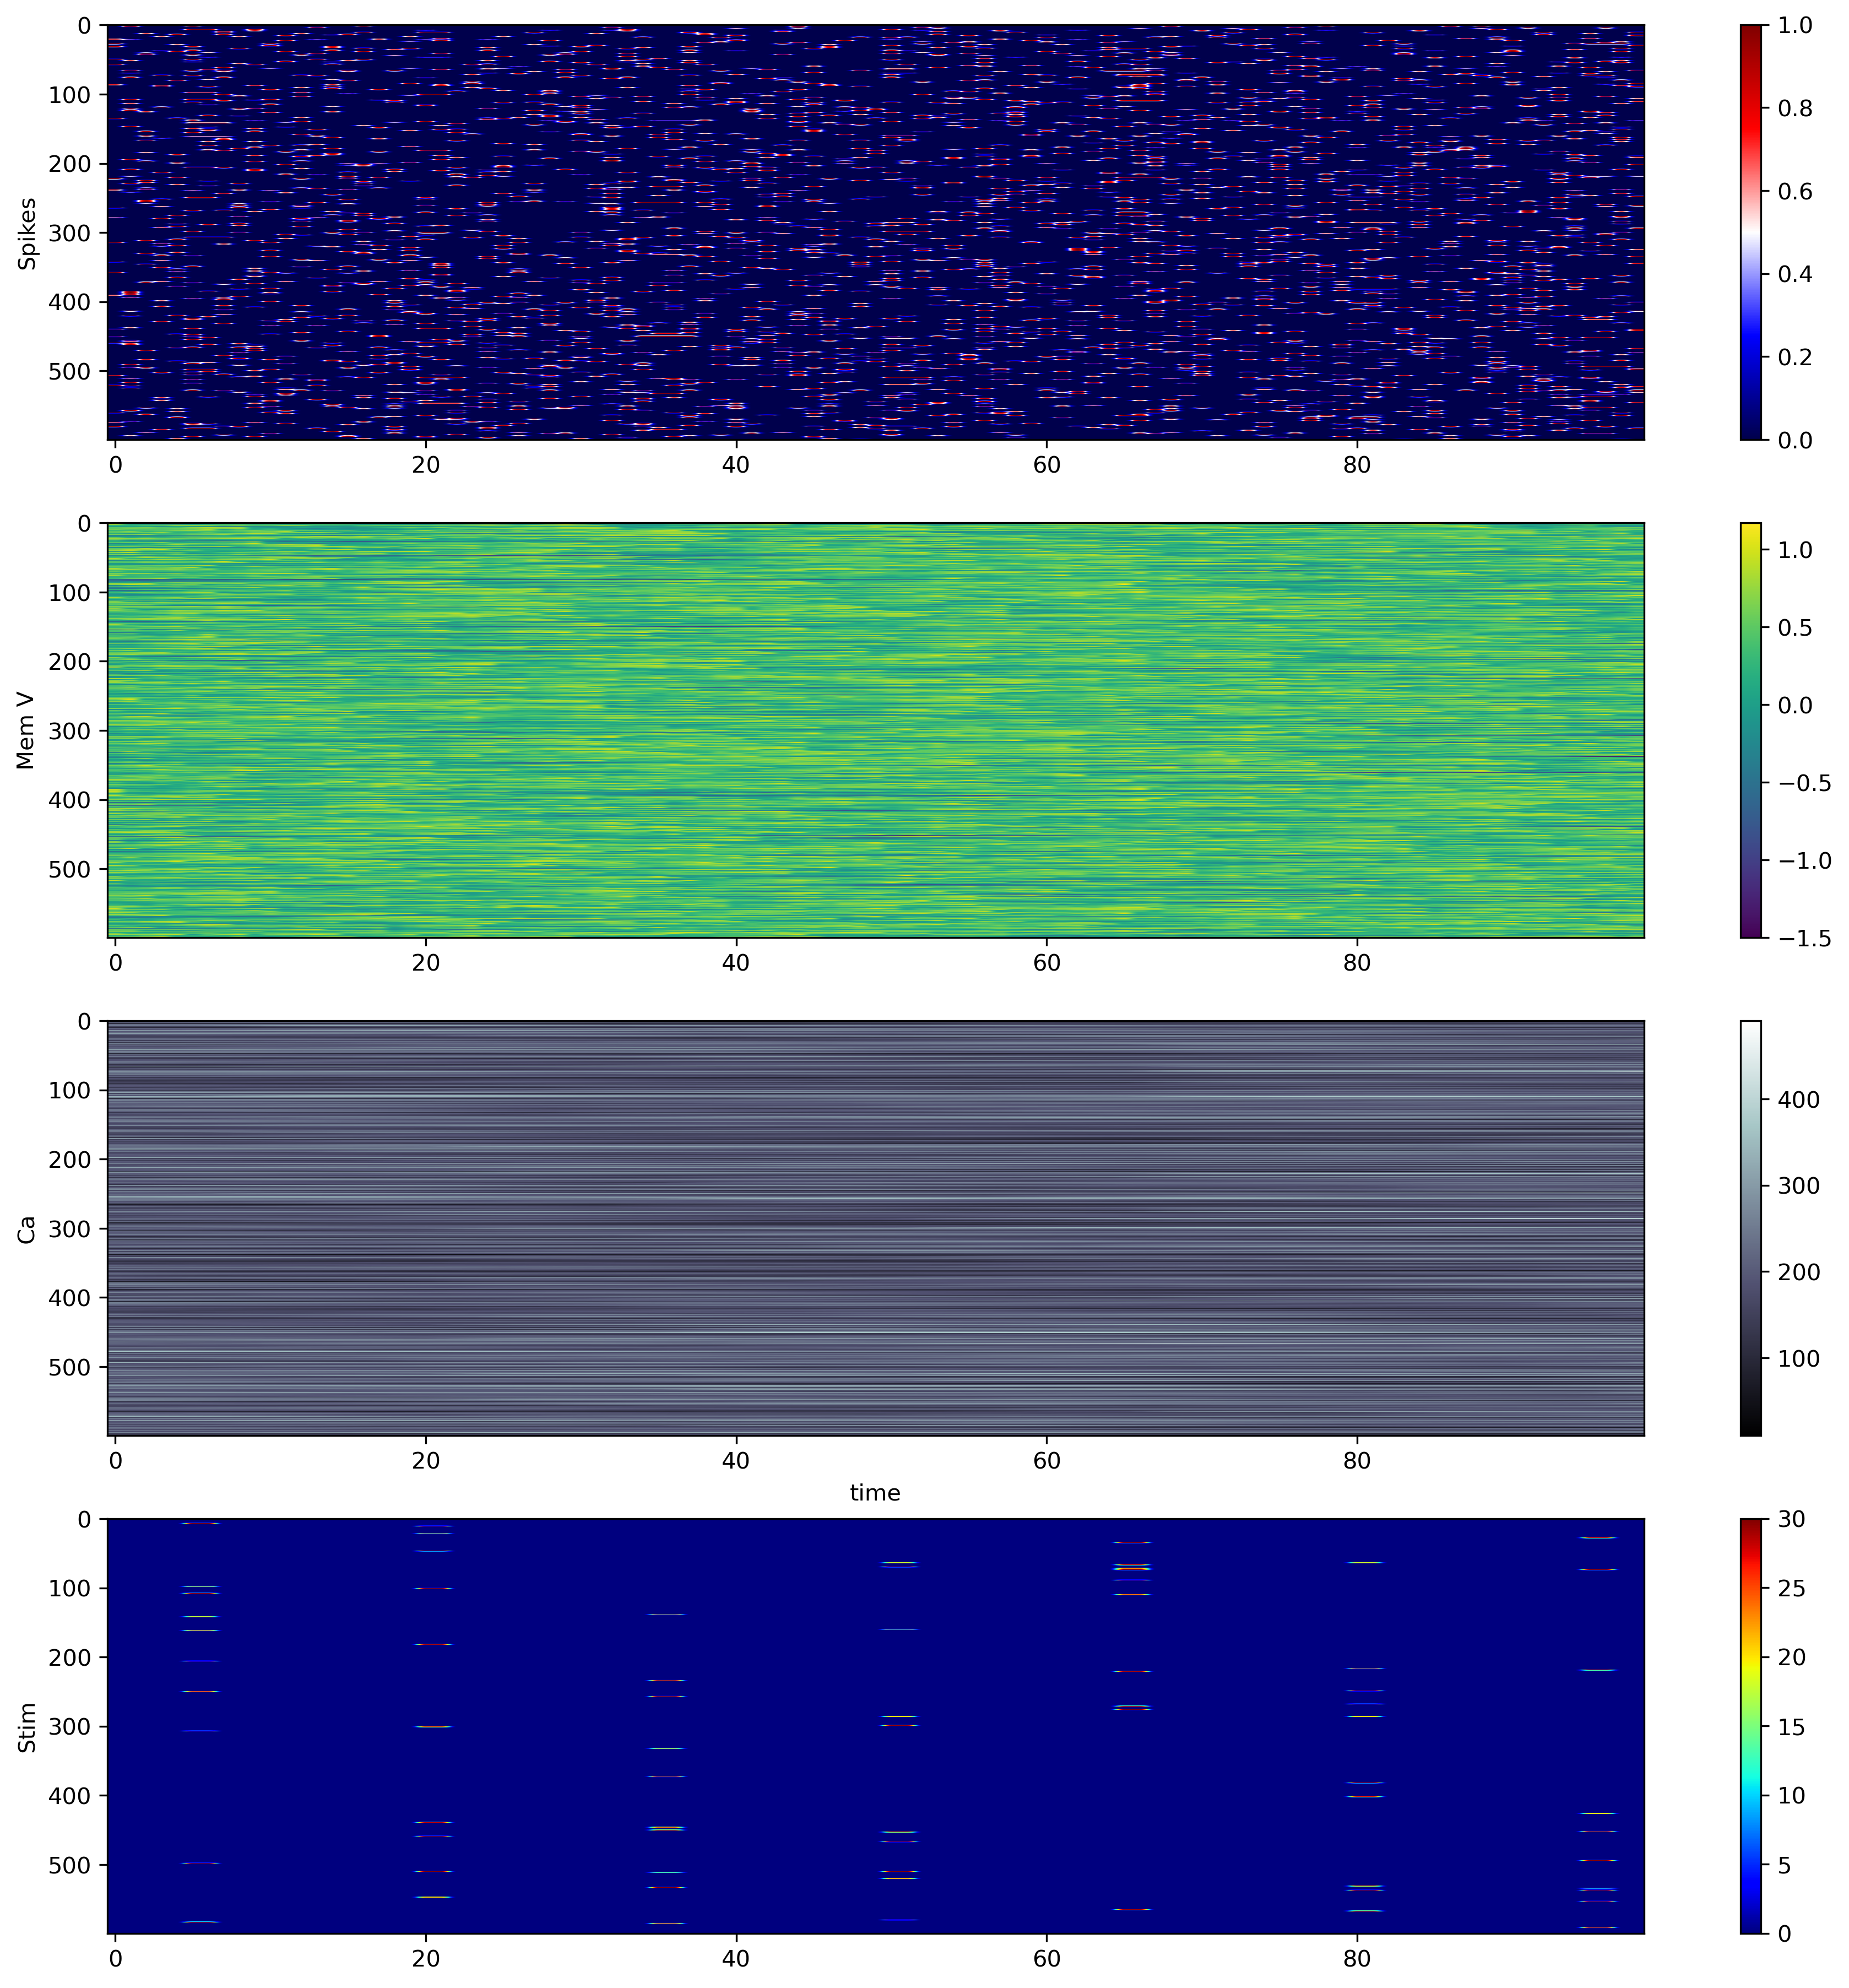

F_vis shape: (2000, 20, 600)
stim_trial_ids: [  39   43  133  286  385  490  613  671  699  906 1107 1139 1239 1254
 1269 1297 1332 1615 1761 1790]
stim_neuron_ids: [ 27 141 224 232 345 349 443 485 505 538]
untargeted_neuron_ids: [0 1 2 3 4 5 6 7 8 9]


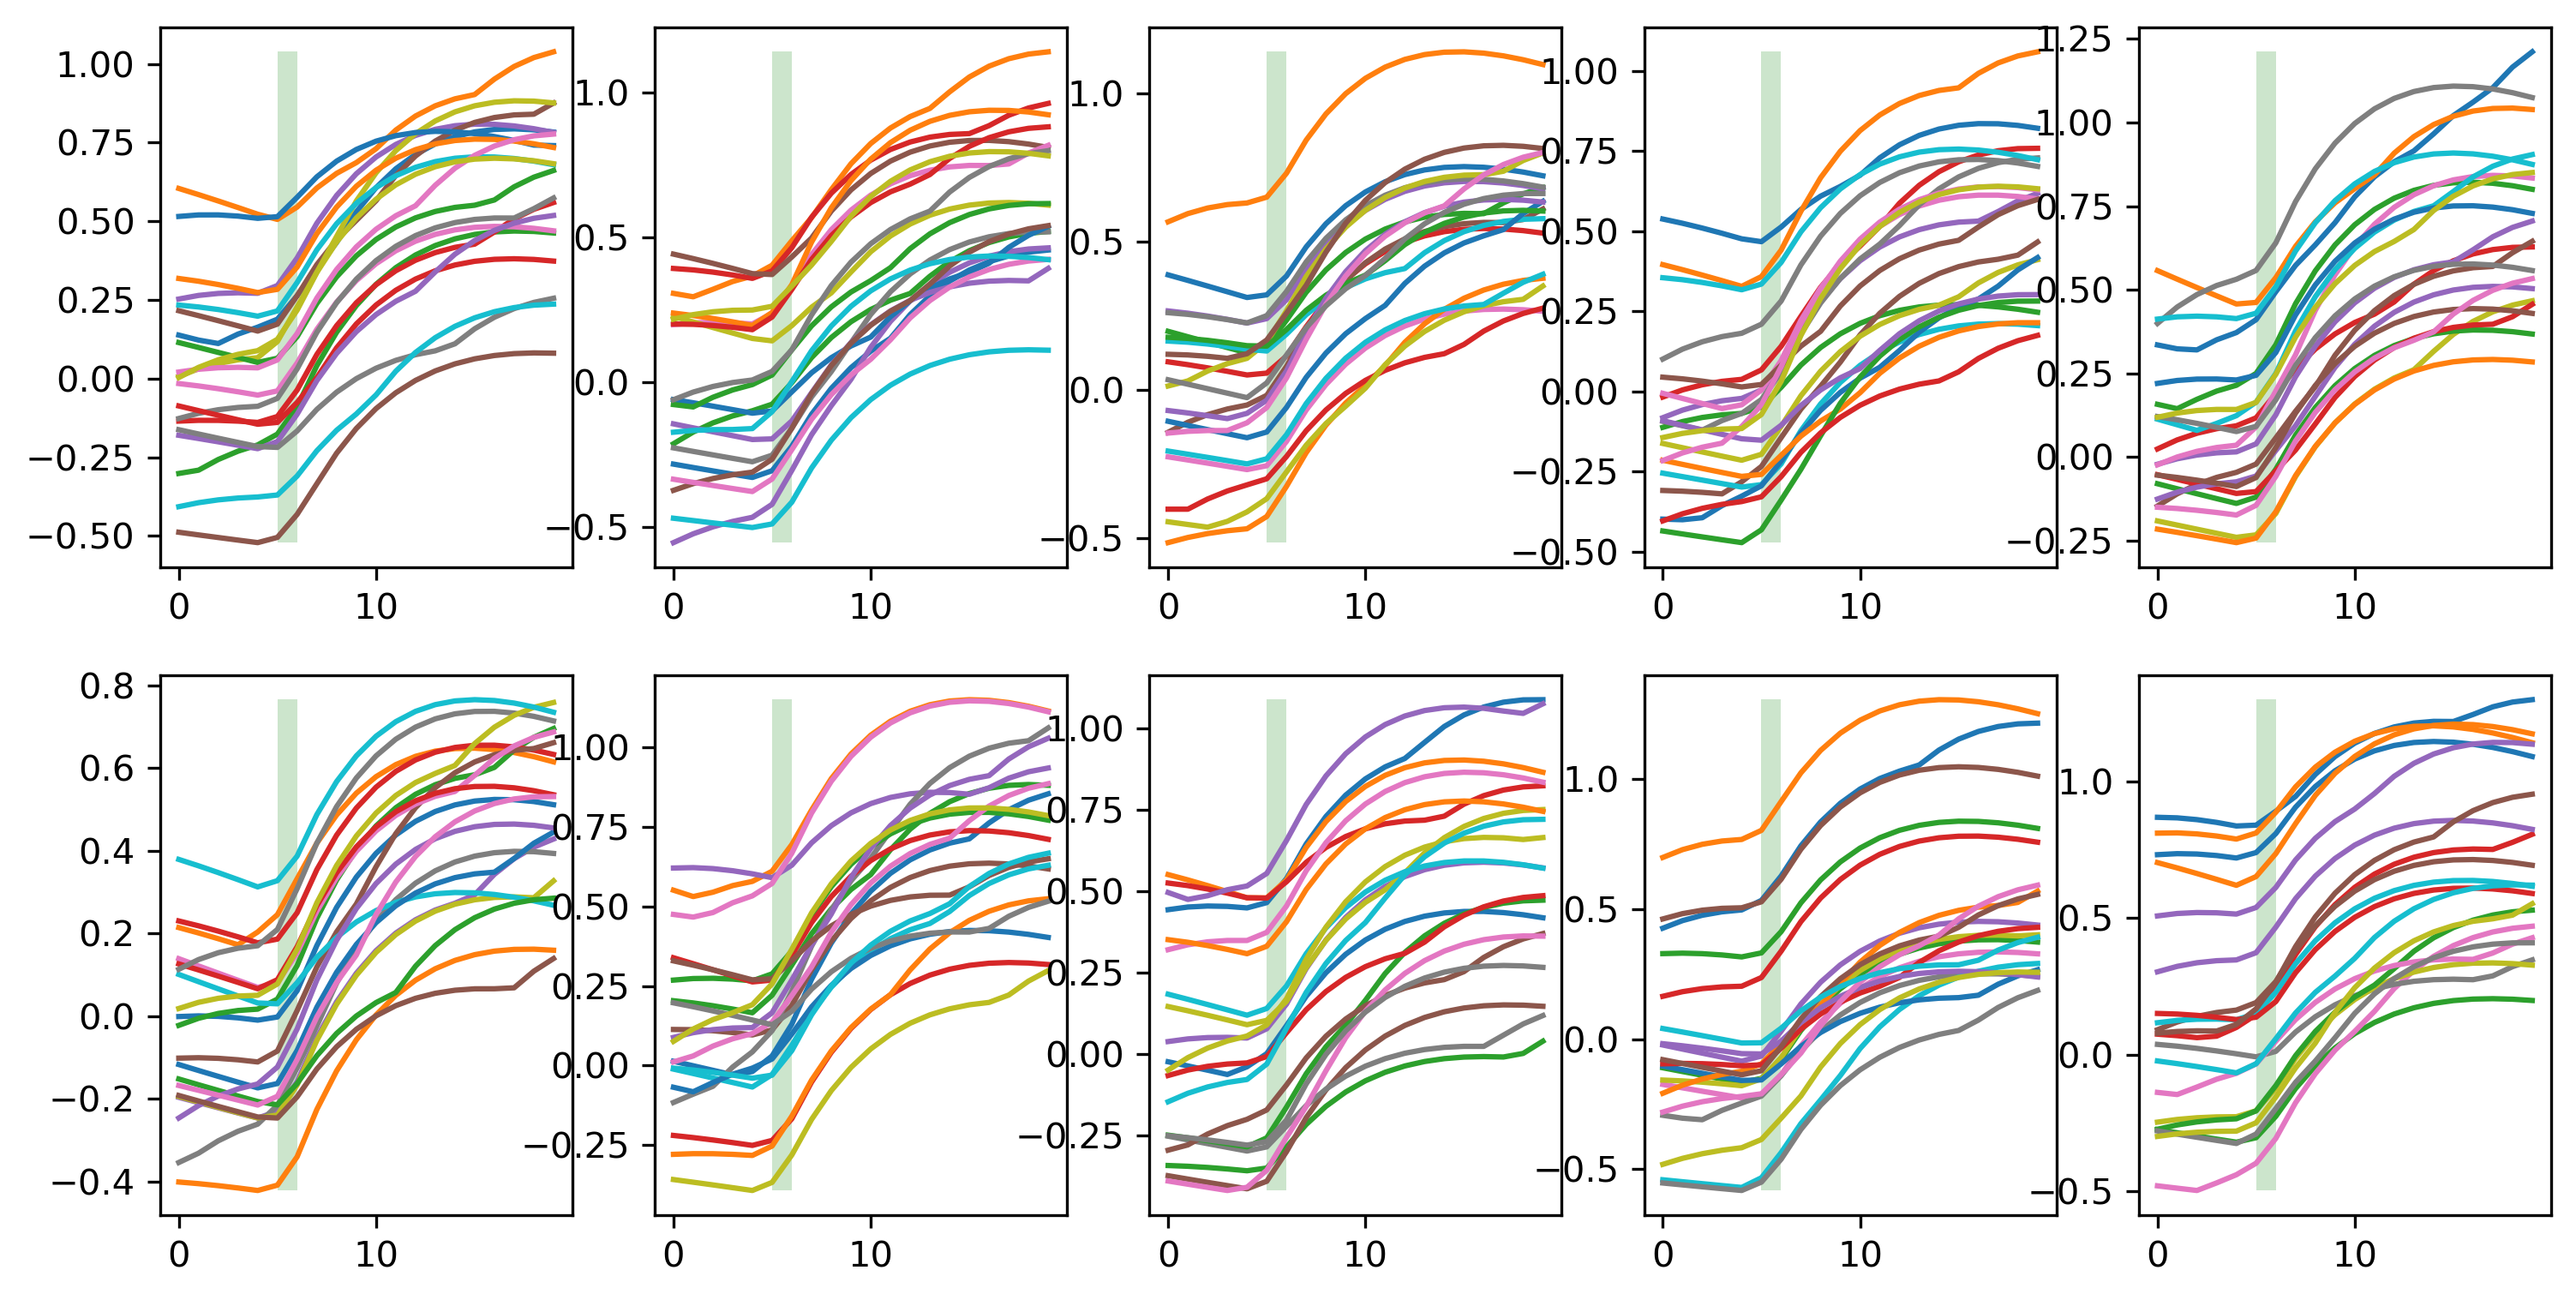

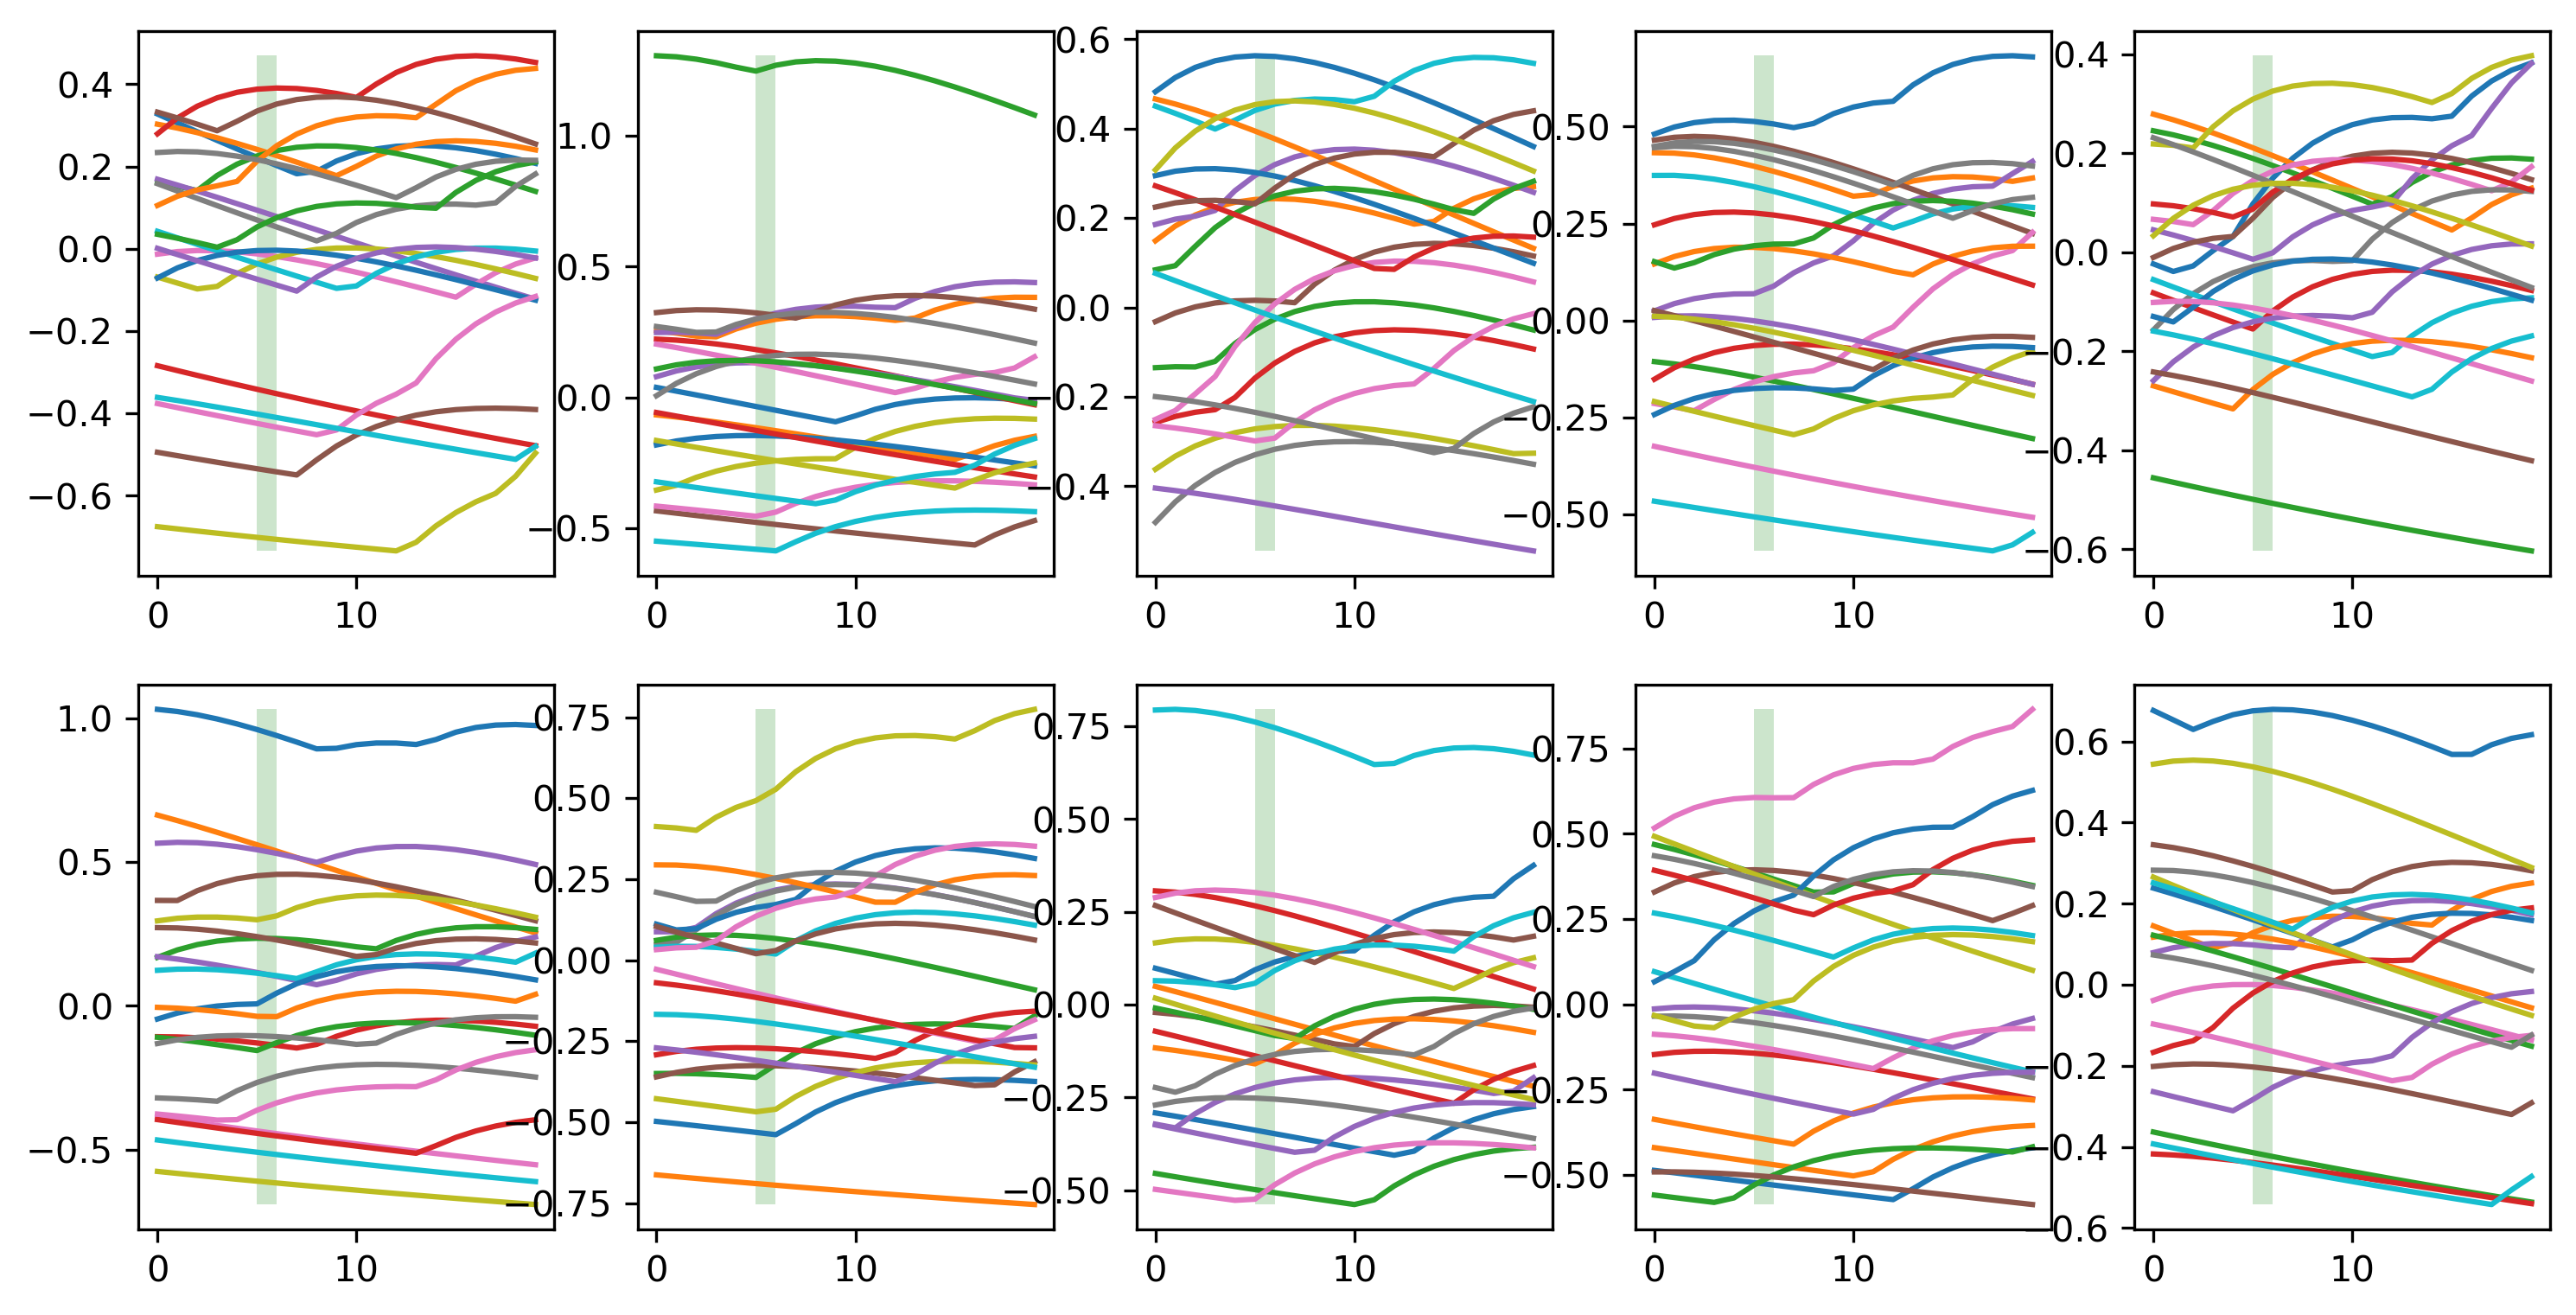

In [4]:
g = 0.9
Iscale = 30
noise = 10
snn, F_vis, input_vis, I_pattern, v_all, Ca_all, Spikes_all, Stimulation_all = generate_data(g = g, Iscale = Iscale, noise = noise)

In [6]:
num_neurons = Ca_all.shape[0]
num_trials = snn.stim.I_stimulation_start.shape[0]
upsample_factor = 1
F_vis_raw = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))
v_vis = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))
spik_vis = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))
input_vis = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))

for i, start_time in enumerate(snn.stim.I_stimulation_start):
    F_vis_raw[i, :, :] = Ca_all[:, int(start_time - pre_stim_step) * upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T
    input_vis[i, :, :] = Stimulation_all[:, int(start_time - pre_stim_step)* upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T
    v_vis[i, :, :] = v_all[:, int(start_time - pre_stim_step)* upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T
    spik_vis[i, :, :] = Spikes_all[:, int(start_time - pre_stim_step)* upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T

print('F_vis shape:', F_vis_raw.shape)
F_baseline = np.mean(np.mean(F_vis_raw[:,:pre_stim_step,:], axis = 0), axis = 0)
F_vis = (F_vis_raw - F_baseline[None, None, :])/F_baseline[None, None, :]

F_vis shape: (2000, 20, 600)


In [7]:
time_steps = int(F_vis.shape[1]/upsample_factor)
F_vis_ds = np.zeros((F_vis.shape[0], time_steps, F_vis.shape[2]))
input_vis_ds = np.zeros((F_vis.shape[0], time_steps, F_vis.shape[2]))
v_vis_ds = np.zeros((v_vis.shape[0], time_steps, v_vis.shape[2]))
for t in range(time_steps):
    F_vis_ds[:,t,:] = F_vis[:,t * upsample_factor,:]
    input_vis_ds[:,t,:] = input_vis[:,t * upsample_factor,:]
    v_vis_ds[:,t,:] = v_vis[:,t * upsample_factor,:]

In [8]:
print(F_vis_ds.shape)
print(input_vis_ds.shape)

(2000, 20, 600)
(2000, 20, 600)


Text(0.5, 0, 'time (s)')

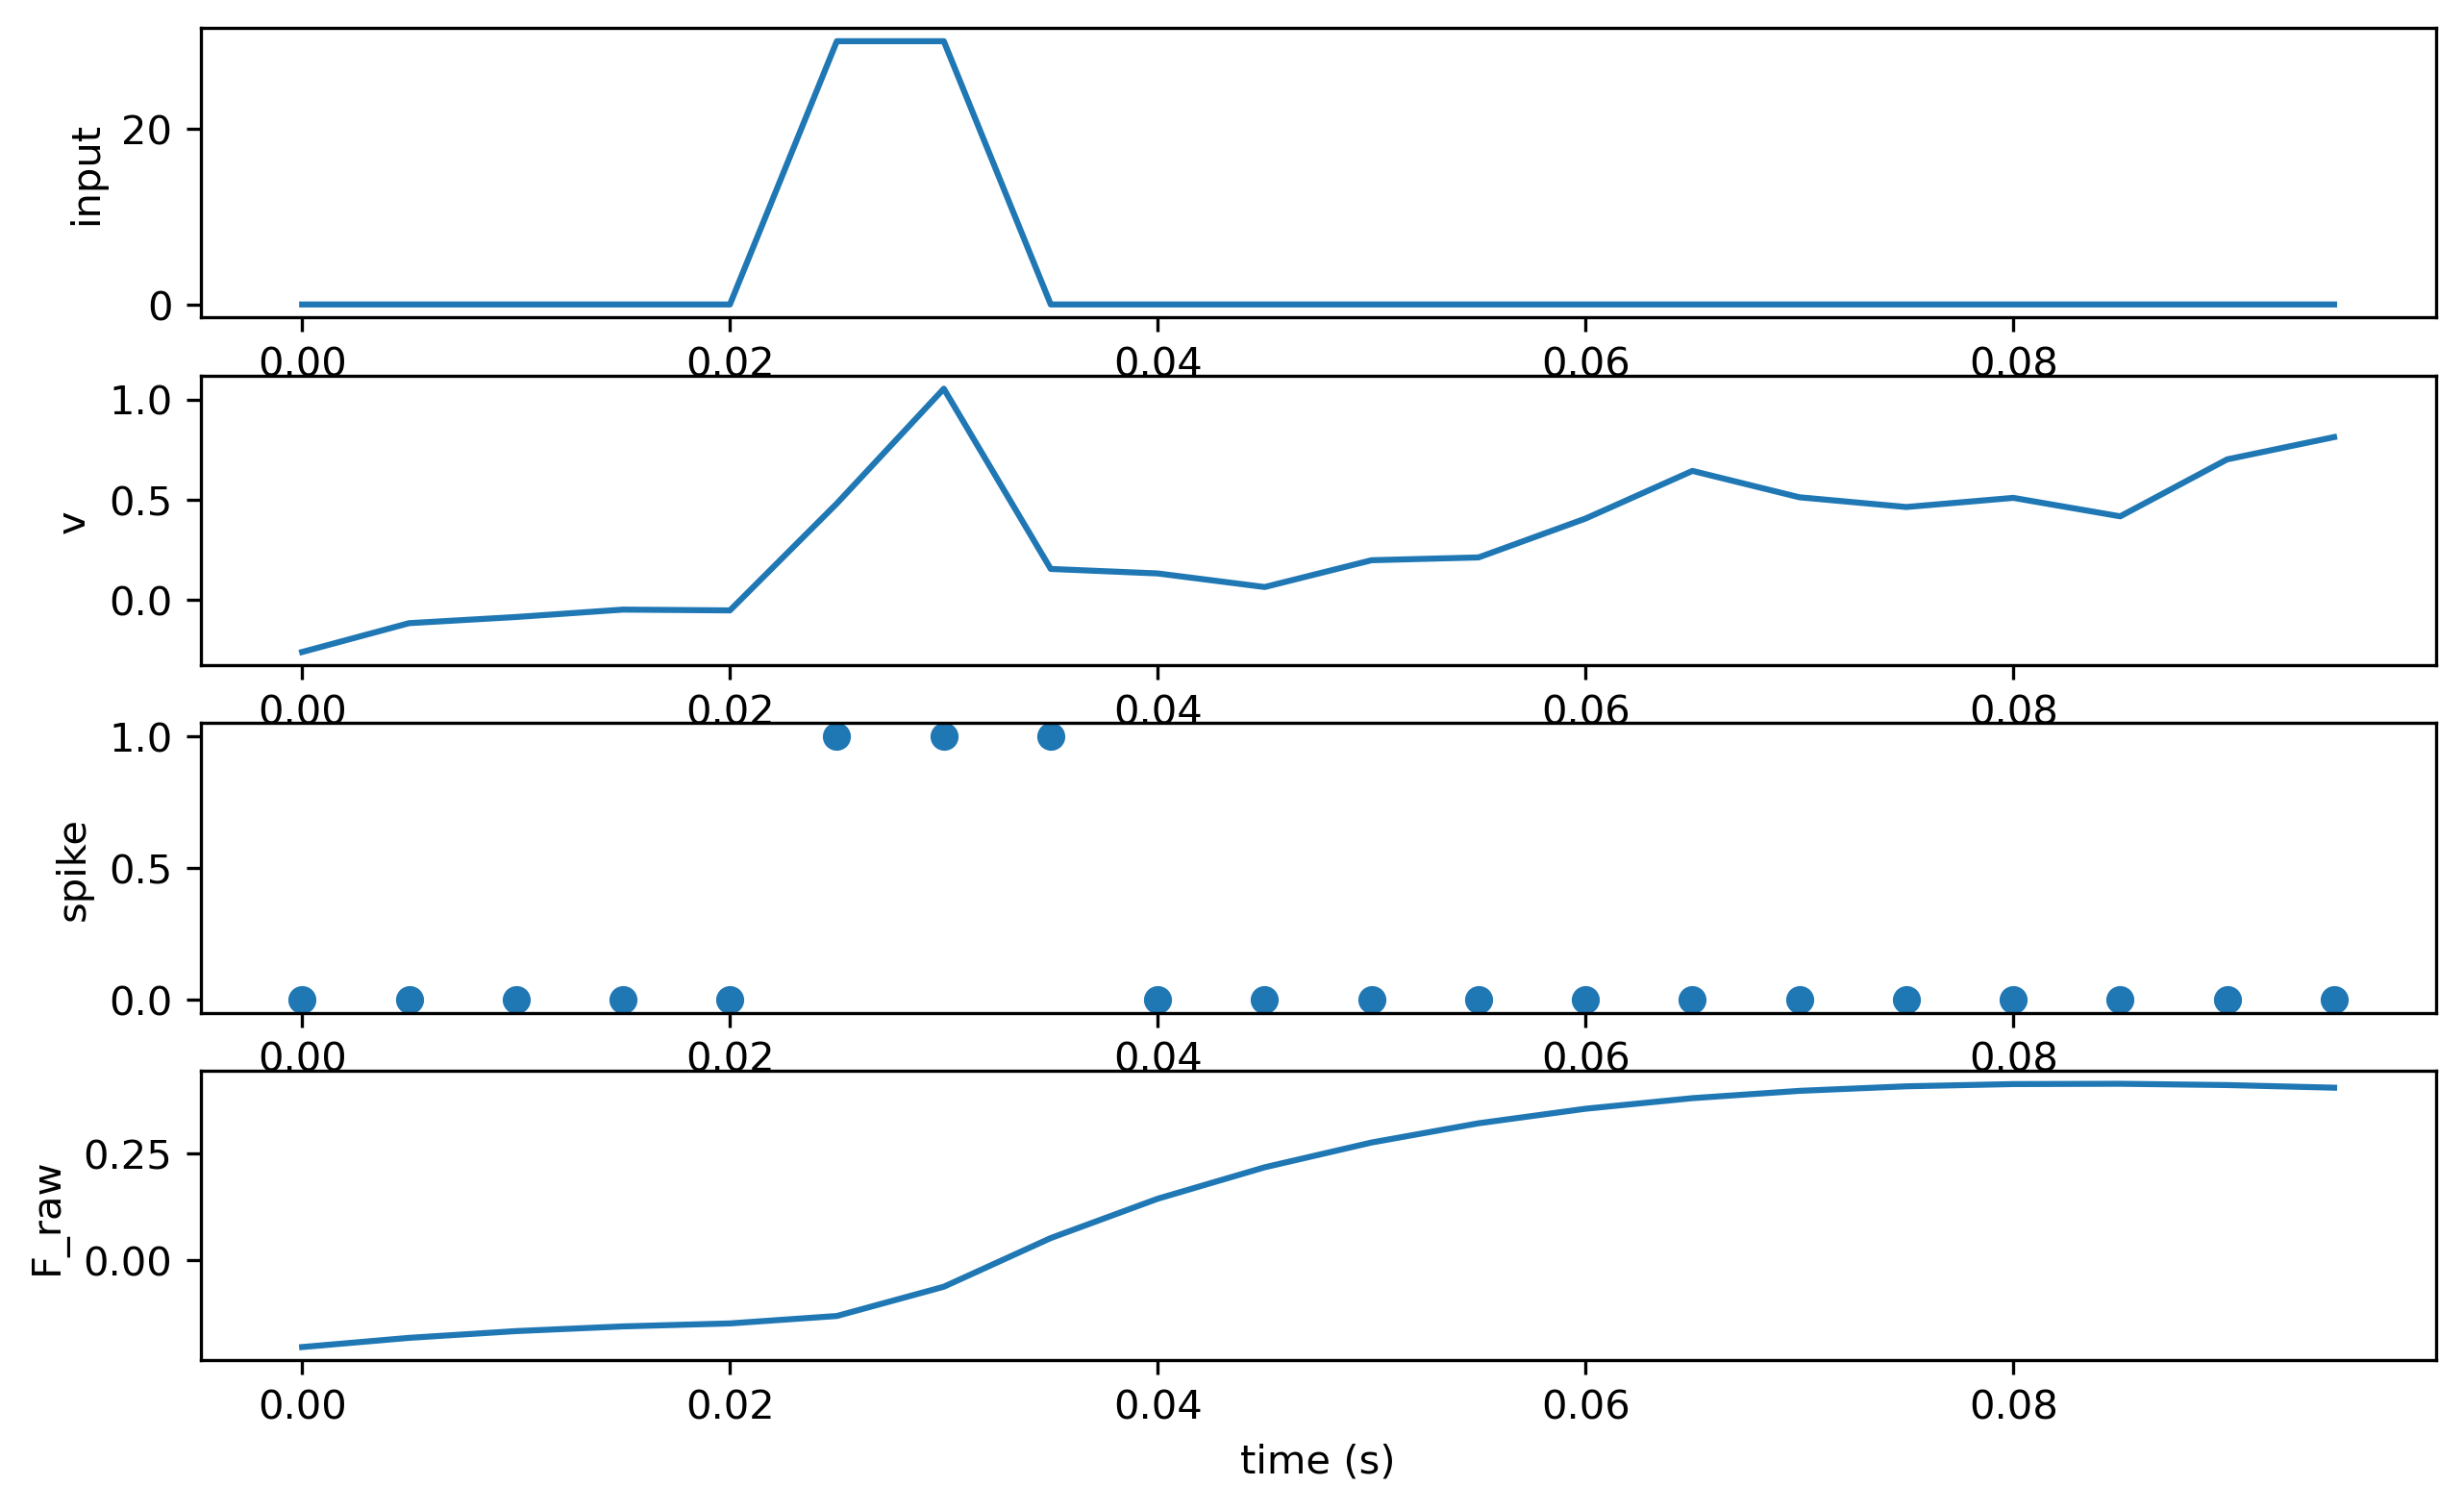

In [9]:
stim_group_id = 60
stim_dt = 0.005
stim_trial_ids = np.where(snn.stim.I_stimulationPattern == stim_group_id)[0]
stim_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==1)[0]
untargeted_all_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==0)[0]
neuron_id = stim_neuron_ids[9]
trial_id = stim_trial_ids[2]
time_steps_ds = np.arange(trial_len) * stim_dt
time_steps = np.arange(trial_len * upsample_factor) * stim_dt
fig, axes = plt.subplots(4,1, figsize=(10, 6))
axes[0].plot(time_steps_ds, input_vis_ds[trial_id, :, neuron_id])
axes[0].set_ylabel('input')
axes[0].set_xlabel('time (s)')
axes[1].plot(time_steps, v_vis.astype('float16')[trial_id, :, neuron_id])
axes[1].set_ylabel('v')
axes[1].set_xlabel('time (s)')
axes[2].plot(time_steps, spik_vis[trial_id, :, neuron_id],'o')
axes[2].set_ylabel('spike')
axes[2].set_xlabel('time (s)')
axes[3].plot(time_steps_ds, F_vis_ds[trial_id, :, neuron_id])
axes[3].set_ylabel('F_raw')
axes[3].set_xlabel('time (s)')

In [10]:
sim_SNN = {'Ca_all': Ca_all,
           'Stimulation_all': Stimulation_all,
           'v_all': v_all,
           'Spikes_all': Spikes_all,
           'F_vis_ds': F_vis_ds,
           'v_vis_ds': v_vis.astype('float16'),
           'input_vis_ds': input_vis_ds,
           'spik_vis': spik_vis.astype(int),
           'stim_order': snn.stim.I_stimulationPattern,
           'stim_pattern': snn.stim.U}

In [11]:
np.save('data/sim_SNN_0404.npy', sim_SNN)